# 1. Import Dependencies

In [4]:
from nes_py.wrappers import JoypadSpace
import gym
import os
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import time
import matplotlib.pyplot as plt

from gym_utils import SMBRamWrapper
import torch

In [5]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# 2. Process Environment

In [6]:
# Setup cropping size
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4

env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)

In [7]:
# test env_wrap
done = True
for i in range(150):
    if done:
        state = env_wrap.reset()
    state, reward, done, info = env_wrap.step(env_wrap.action_space.sample())

In [8]:
state.shape

(13, 16, 4)

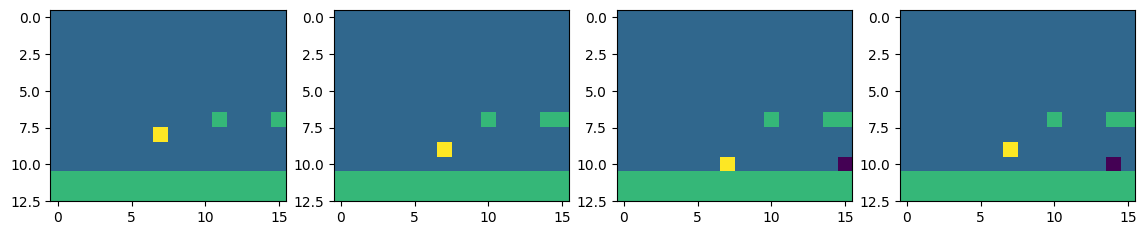

In [9]:
fig, ax = plt.subplots(1, n_stack, figsize=(14,10))
for i in range(n_stack):
    ax[i].imshow(state[:,:,n_stack-i-1], vmin=-1, vmax=2)
plt.show()

In [10]:
# Apply other wrapper functions
env_wrap = Monitor(env_wrap)  # for tensorboard log
env_wrap = DummyVecEnv([lambda: env_wrap])

# 3. Setup RL Model

In [ ]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from typing import Callable


class ModelCheckpointCallback(BaseCallback):
    """
    Callback for saving model checkpoints during training at specified intervals.
    
    This callback saves the model periodically based on the number of training steps.
    """
    
    def __init__(self, 
                 save_frequency: int, 
                 checkpoint_dir: str, 
                 initial_step_count: int = 0, 
                 verbose: int = 1):
        """
        Initialize the checkpoint callback.
        
        Args:
            save_frequency (int): How often to save the model (in steps)
            checkpoint_dir (str): Directory path to save model checkpoints
            initial_step_count (int): Starting step count if resuming training
            verbose (int): Verbosity level (0: no output, 1: info)
        """
        super(ModelCheckpointCallback, self).__init__(verbose)
        self.save_frequency = save_frequency
        self.checkpoint_dir = checkpoint_dir
        self.initial_step_count = initial_step_count
    
    def _init_callback(self):
        """Create the checkpoint directory if it doesn't exist."""
        if self.checkpoint_dir is not None:
            os.makedirs(self.checkpoint_dir, exist_ok=True)
    
    def _on_step(self):
        """
        Save the model when the specified number of steps has been reached.
        
        Returns:
            bool: Whether training should continue (always True)
        """
        if self.n_calls % self.save_frequency == 0:
            total_steps = self.n_calls + self.initial_step_count
            checkpoint_path = os.path.join(
                self.checkpoint_dir, 
                f'model_checkpoint_{total_steps}'
            )
            self.model.save(checkpoint_path)
            if self.verbose > 0:
                print(f"Saved model checkpoint at {total_steps} steps")
        
        return True


def linear_learning_rate_schedule(initial_lr: float) -> Callable[[float], float]:
    """
    Creates a linear learning rate decay schedule.
    
    The learning rate decreases linearly from the initial value to zero
    as training progresses from start to finish.
    
    Args:
        initial_lr (float): The starting learning rate
        
    Returns:
        callable: A function that computes the current learning rate
                 based on remaining progress
    """
    def scheduler(progress_remaining: float) -> float:
        """
        Calculate current learning rate based on remaining progress.
        
        Args:
            progress_remaining (float): Value from 1.0 (training start) 
                                      to 0.0 (training end)
        
        Returns:
            float: Current learning rate
        """
        return progress_remaining * initial_lr
    
    return scheduler

In [ ]:
MODEL = './models/v3'
LOG = './logs/v3'
model = PPO('MlpPolicy', env_wrap, verbose=1, learning_rate=linear_learning_rate_schedule(3e-4), tensorboard_log=LOG)

Using cpu device


In [ ]:
callback = ModelCheckpointCallback(check_freq=1e5, starting_steps=0, save_path=MODEL)

# Train the model

In [ ]:
t_start = time.time()

model.learn(total_timesteps=10e6, callback=callback)

t_elapsed = time.time() - t_start

Logging to ./logs/v3\PPO_1


f:\MarioML\venv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-----------------------------
| time/              |      |
|    fps             | 232  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 304         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012359112 |
|    clip_fraction        | 0.0832      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.00135    |
|    learning_rate        | 0.0003      |
|    loss                 | 17.9        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 50.9        |
-----------------------------------------
----------------------------------

In [ ]:
print('Wall time: {} s'.format(round(t_elapsed, 2)))

# Save and load trained model

In [ ]:
# Save model
model_path = os.path.join(MODEL, 'mario_v1')
model.save(model_path)

In [ ]:
del model

In [ ]:
# Load model
MODEL = './models/v3/best_model_7100000'
LOG = './logs/v3/PPO_1'

model_path = MODEL
model = PPO.load(model_path, env=env_wrap)

# 4. Test Our Model

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)

episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))
#env.close()